In [139]:
import pandas as pd

In [140]:
heart_df = pd.read_csv("./data/SAheart.data")

In [141]:
heart_df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [142]:
heart_df.shape

(462, 11)

### 1. how many heart disease vs no heart diseases`
### 2. Does family history has any effect on heart attack?
### 3. How age, alcohol, tobacco impacts heart disease
### 4. What is correlation sbp, ldl, typea and obesity
### 5. Probability of heart disease if age > 50

In [143]:
import matplotlib.pyplot as plt

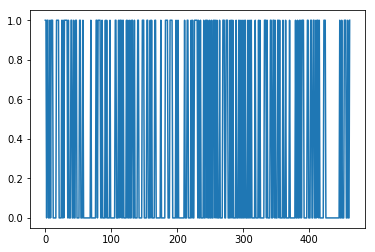

In [144]:
plt.plot(heart_df.chd)

In [145]:
having=heart_df[heart_df.chd==1].shape

In [146]:
not_having=heart_df[heart_df.chd==0].shape

In [147]:
heart_df.shape

(462, 11)

No handles with labels found to put in legend.


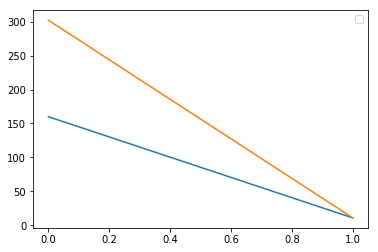

In [148]:
plt.plot(having)
plt.plot(not_having)
plt.legend()

In [149]:
heart_df['family'] = heart_df['famhist'].map(lambda s: int(s == 'Present'))

In [150]:
x_features = list(heart_df.columns)

In [151]:
x_features

['row.names',
 'sbp',
 'tobacco',
 'ldl',
 'adiposity',
 'famhist',
 'typea',
 'obesity',
 'alcohol',
 'age',
 'chd',
 'family']

In [152]:
x_features.remove('row.names')

In [153]:
x_features.remove('famhist')

In [154]:
x_features.remove('chd')

In [155]:
x_features

['sbp',
 'tobacco',
 'ldl',
 'adiposity',
 'typea',
 'obesity',
 'alcohol',
 'age',
 'family']

In [156]:
from sklearn.model_selection import train_test_split


In [157]:
x_train, x_test,\
y_train, y_test = train_test_split(heart_df[x_features],
                                  heart_df.chd,
                                  train_size=0.8,
                                  random_state = 100)

C:\Users\dhimate\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [158]:
from sklearn.tree import DecisionTreeClassifier

In [159]:
tree_v1 = DecisionTreeClassifier(max_depth=5)

In [160]:
tree_v1.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [161]:
y_pred_tree_v1 = tree_v1.predict(x_test)

In [162]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [163]:
cm_tree_v1 = confusion_matrix(y_test, y_pred_tree_v1, [1,0])

Text(33.0, 0.5, 'actual')

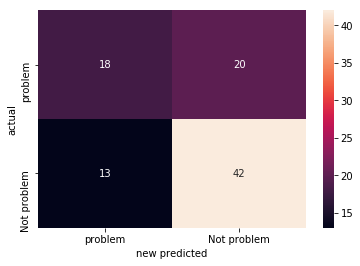

In [164]:
sn.heatmap(cm_tree_v1, fmt="0.0f", xticklabels=['problem', 'Not problem'], yticklabels=['problem', 'Not problem'], annot=True)
plt.xlabel('new predicted')
plt.ylabel('actual')

In [165]:
from sklearn.tree import export_graphviz

In [166]:
tree = export_graphviz(tree_v1, out_file='tree_heart.odt',feature_names=x_features, class_names=['Not Left','Left'], filled=True)

In [167]:
import pydotplus as pdt

In [168]:
graph = pdt.graphviz.graph_from_dot_file('tree_heart.odt')

In [169]:
graph.write_jpg('tree_heart.jpg')

True

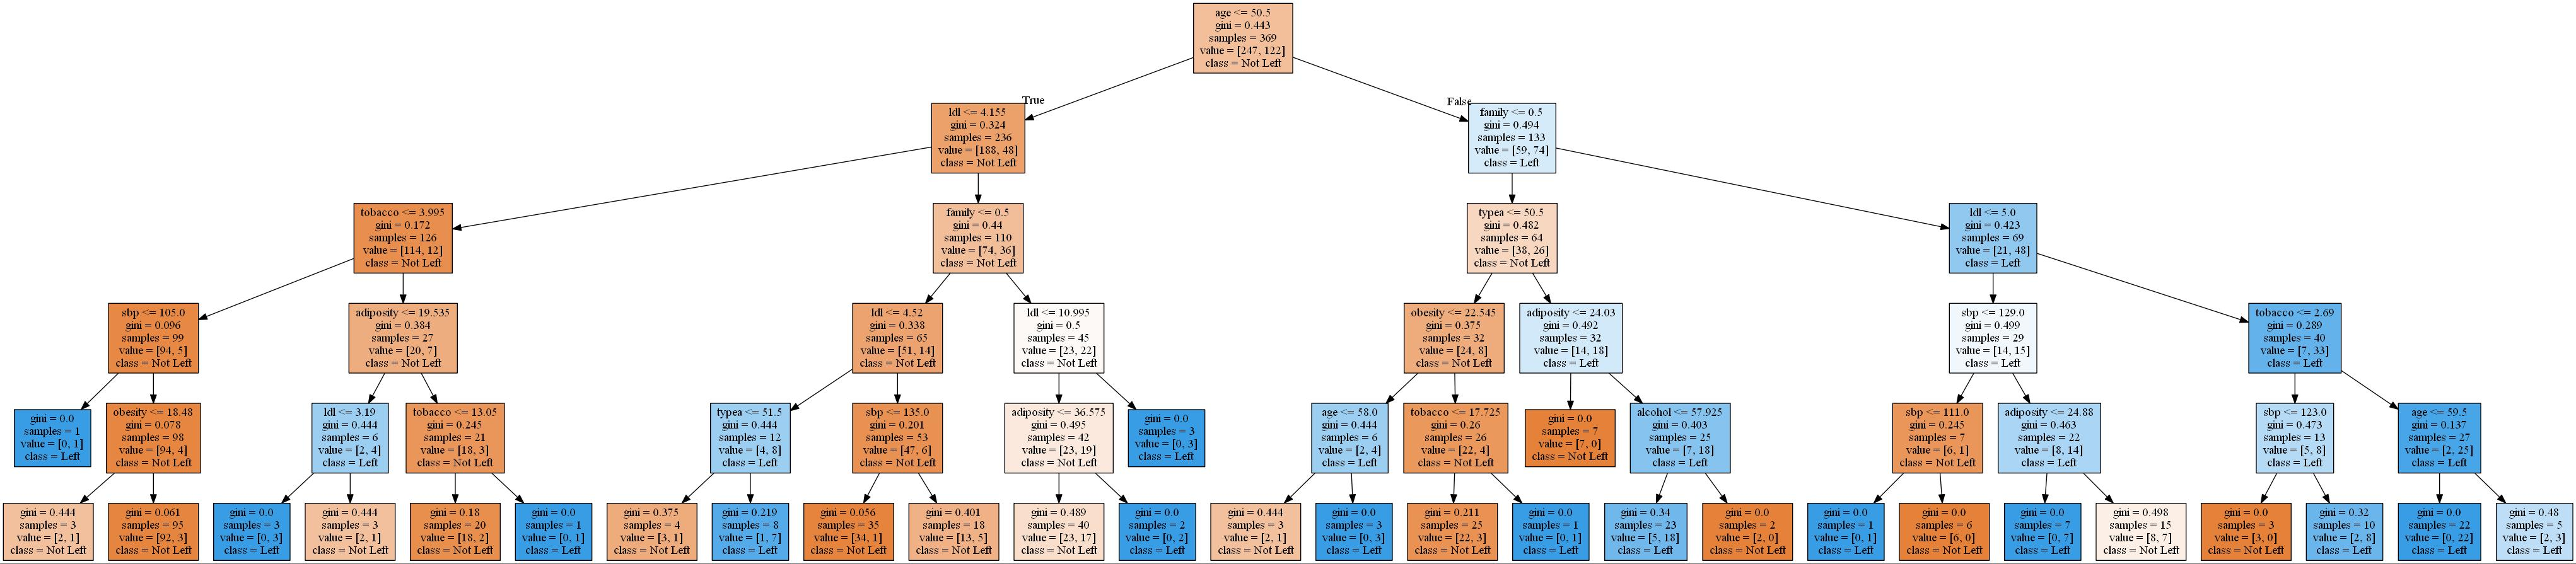

In [170]:
from IPython.display import Image
Image(filename='tree_heart.jpg')

### finding optimal cut off

In [171]:
FP_Cost = 1.0
FM_Cost = 5.0

In [172]:
y_tree_v1 = pd.DataFrame({'actual': y_test,
                       'predicted' : y_pred_tree_v1})

In [173]:
y_tree_v1['prob'] = tree_v1.predict_proba(x_test)[:,1]

In [174]:
def get_Cost(cutoff) :
    y_tree_v1['new_Predict'] = y_tree_v1.prob.map(lambda x: 1 if x >= cutoff else 0)
    cm_v1_new = confusion_matrix(y_tree_v1.actual,y_tree_v1.new_Predict, [1,0])
    return FP_Cost * cm_v1_new[1][0] + FM_Cost * cm_v1_new[0][1]

In [175]:
import numpy as np

In [176]:
cutoff_list = np.arange(0.1,0.8,0.01)

In [177]:
cost_list = [get_Cost(x) for x in cutoff_list]

In [178]:
cost_df = pd.DataFrame({'cutoff' : cutoff_list,
                       'cost' : cost_list})

In [179]:
cost_df.sort_values('cost', ascending=True)[0:10]

,cutoff,cost
0,0.10,77.0
1,0.11,82.0
2,0.12,82.0
17,0.27,99.0
16,0.26,99.0
15,0.25,99.0
14,0.24,99.0
13,0.23,99.0
12,0.22,99.0
11,0.21,99.0


In [180]:
y_tree_v1['final_pred'] = y_tree_v1.prob.map(lambda x: 1 if x >= 0.10 else 0)

In [181]:
from sklearn.metrics import classification_report

In [182]:
print(classification_report(y_tree_v1.actual, y_tree_v1.final_pred))

              precision    recall  f1-score   support

           0       0.72      0.42      0.53        55
           1       0.48      0.76      0.59        38

   micro avg       0.56      0.56      0.56        93
   macro avg       0.60      0.59      0.56        93
weighted avg       0.62      0.56      0.55        93



In [183]:
tree_v1 = DecisionTreeClassifier(max_depth=5)

In [184]:
tree_v1.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [185]:
y_pred_tree_v1 = tree_v1.predict(x_test)

In [186]:
cm_tree_v1 = confusion_matrix(y_test, y_pred_tree_v1, [1,0])

Text(33.0, 0.5, 'actual')

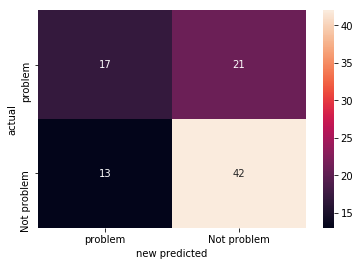

In [187]:
sn.heatmap(cm_tree_v1, fmt="0.0f", xticklabels=['problem', 'Not problem'], yticklabels=['problem', 'Not problem'], annot=True)
plt.xlabel('new predicted')
plt.ylabel('actual')

In [188]:
tree = export_graphviz(tree_v1, out_file='tree_custom.odt',feature_names=x_features, class_names=['Not Left','Left'], filled=True)

In [189]:
graph = pdt.graphviz.graph_from_dot_file('tree_custom.odt')

In [190]:
graph.write_jpg('tree_custom.jpg')

True

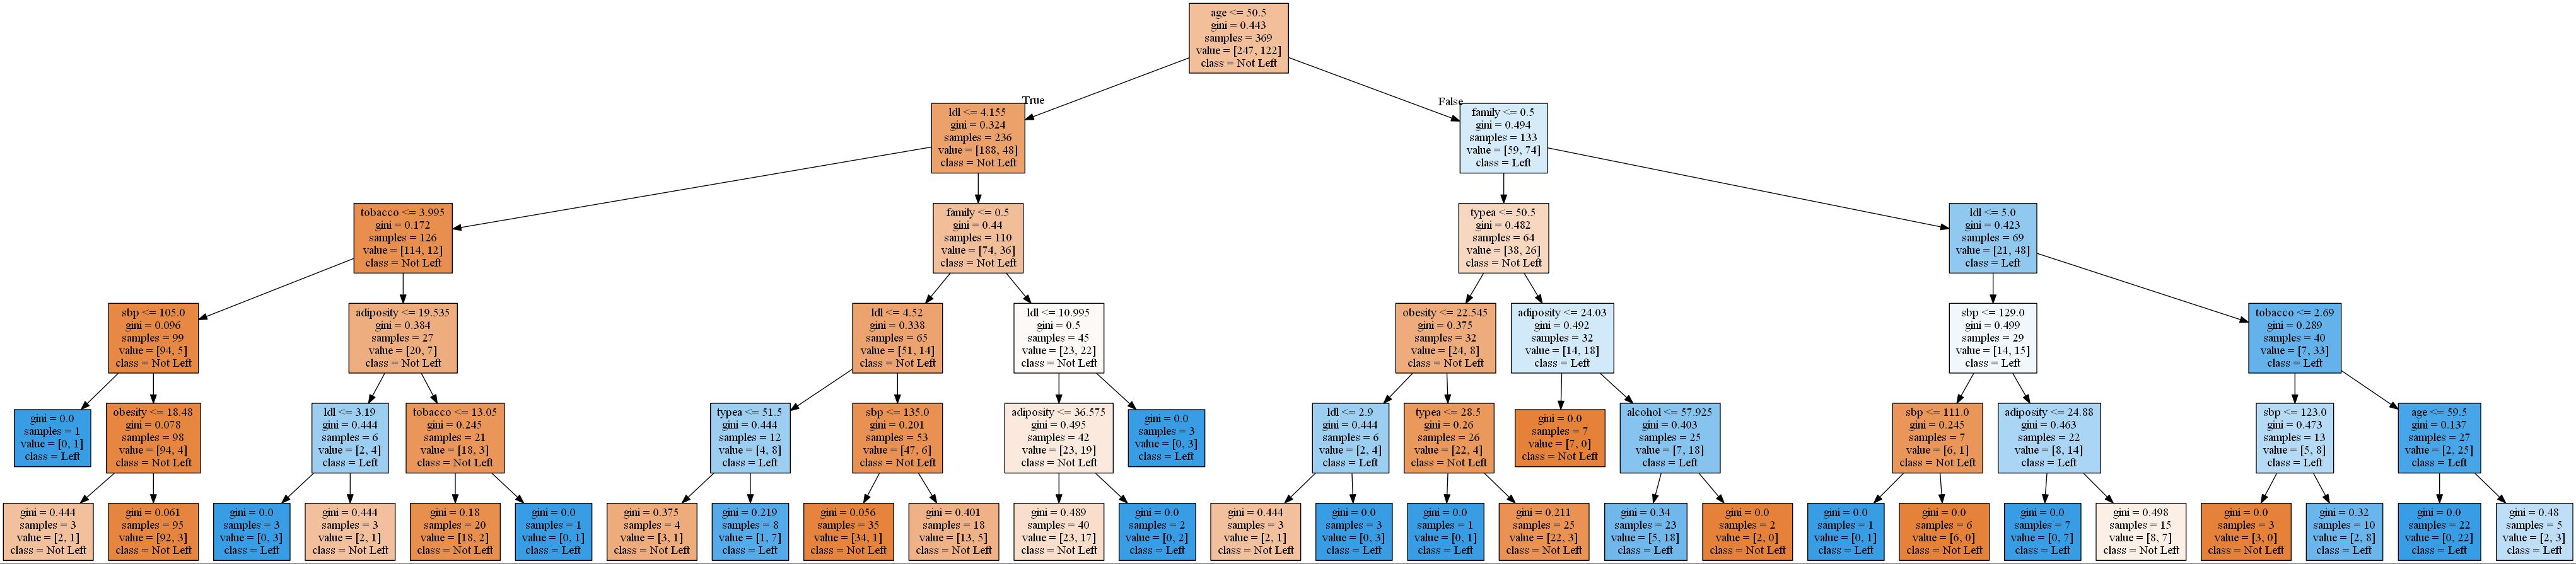

In [191]:
from IPython.display import Image
Image(filename='tree_custom.jpg')